In [1]:
!pip install pandas matplotlib seaborn shapely

In [2]:
#importing all the necessary libraries
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from shapely.geometry import Point, Polygon

In [3]:
#loading the CSV files using pandas
vessel_positions = pd.read_csv("vessel_positions.csv")
vessel_characteristics = pd.read_csv("vessel_characteristics.csv")

/var/folders/sz/12qww74x6dq8j6zqvj0g1ft00000gn/T/ipykernel_36557/3676646262.py:2: DtypeWarning: Columns (13,14,20,21,25,26,29,30,32,51) have mixed types. Specify dtype option on import or set low_memory=False.
  vessel_positions = pd.read_csv("vessel_positions.csv")
/var/folders/sz/12qww74x6dq8j6zqvj0g1ft00000gn/T/ipykernel_36557/3676646262.py:3: DtypeWarning: Columns (42,47,72,81,154,163,210) have mixed types. Specify dtype option on import or set low_memory=False.
  vessel_characteristics = pd.read_csv("vessel_characteristics.csv")


In [4]:
#cleaning vessel_positions
#first we look at the percentage of missing values, if the missing values are greater than 65%, we will drop it

vp_cols_missing_percentage = vessel_positions.isnull().mean() *100
columns_to_drop = vp_cols_missing_percentage[vp_cols_missing_percentage > 65].index
cleaned_VP = vessel_positions.drop(columns=columns_to_drop)

In [5]:
#Deleting the rows where the exit time is greater than the entrance time as this data makes no sense
cleaned_VP['zone_entry_time'] = pd.to_datetime(cleaned_VP['zone_entry_time'], errors= 'coerce')
cleaned_VP['zone_out_time'] = pd.to_datetime(cleaned_VP['zone_out_time'], errors= 'coerce')
condition = (cleaned_VP['zone_out_time'] < cleaned_VP['zone_entry_time'])
cleaned_VP = cleaned_VP[~condition]

/var/folders/sz/12qww74x6dq8j6zqvj0g1ft00000gn/T/ipykernel_36557/3655759534.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  cleaned_VP['zone_entry_time'] = pd.to_datetime(cleaned_VP['zone_entry_time'], errors= 'coerce')
/var/folders/sz/12qww74x6dq8j6zqvj0g1ft00000gn/T/ipykernel_36557/3655759534.py:3: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  cleaned_VP['zone_out_time'] = pd.to_datetime(cleaned_VP['zone_out_time'], errors= 'coerce')


In [6]:
cleaned_VP.head()

,index,imo,vessel_dwt,status_date_time,in_blackout,ais_speed,ais_draft,vessel_speed_ratio,ais_lat,ais_long,...,real_destination_country_name,real_destination_zone_id,real_destination_zone_name,vessel_operational_status,vessel_commodity_onboard,vessel_commodity_group_onboard,voyage_intake_mt,last_seen,during_cabotage_voyage,vessel_operational_status_group
0,0,1014149,11717,20/08/2024,0,0.0,5.1,NaN,34.3504,133.877,...,Japan,73.0,Far East,waiting_load,NaN,NaN,NaN,19/08/2024 23:56,1,at_port_waiting_load_group
1,1,1014163,39815,20/08/2024,0,0.0,6.1,NaN,-33.8022,137.052,...,China,73.0,Far East,at_port_load,Grain,Grain,27320.0,19/08/2024 23:56,0,in_port_loading_group
2,2,1014199,11722,20/08/2024,0,0.0,4.4,NaN,34.4042,133.425,...,Japan,73.0,Far East,waiting_load,NaN,NaN,NaN,19/08/2024 23:59,1,at_port_waiting_load_group
3,3,1014254,13465,20/08/2024,0,11.8,9.5,NaN,11.7398,109.489,...,Japan,73.0,Far East,at_sea_laden,Steels,Steels,12353.0,19/08/2024 23:59,1,at_sea_laden_group
4,4,1014591,39415,20/08/2024,0,11.0,10.6,NaN,16.4267,113.858,...,NaN,NaN,NaN,at_sea_laden,Steels,Steels,36350.0,19/08/2024 23:52,0,at_sea_laden_group


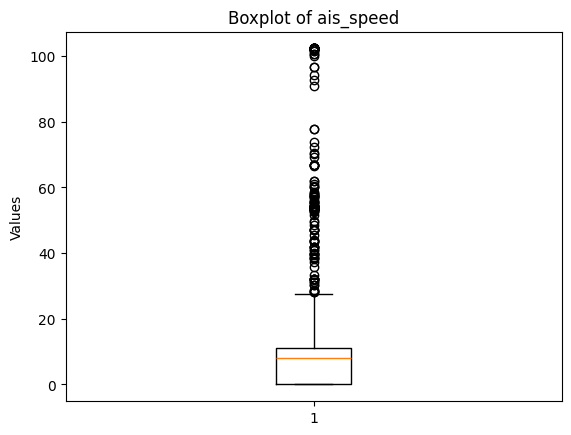

In [7]:
#checking the ais_speed to see if we have any outliers, we will be using boxplot for this

plt.boxplot(cleaned_VP['ais_speed'])
plt.title('Boxplot of ais_speed')
plt.ylabel('Values')
plt.show()

The box plot suggests that we have a number of outliers on our hand, the data is right skewed and some of the values simply don't make sense. The reason it doesn't make sense is that commercial vessels are not capable of travelling at those speeds. For this reason the ais_speed values are going to be clipped, the max value will be set to 30 knots, as that is the max speed commercial vessels can travel at.

In [8]:
upper_limit = 30
cleaned_VP['ais_speed'] = cleaned_VP['ais_speed'].clip(upper=upper_limit)

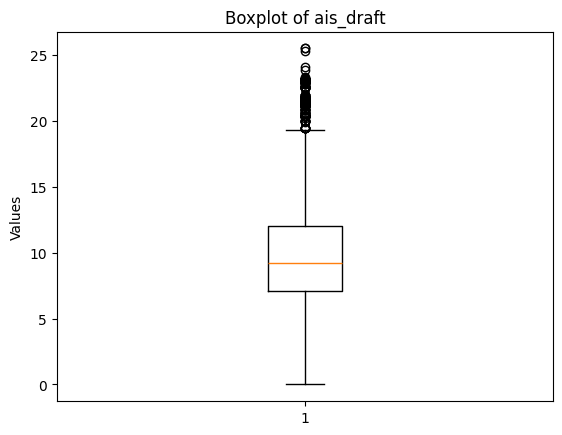

In [9]:
#checking the ais_draft to see if we have any outliers, we will use boxplot for this

plt.boxplot(cleaned_VP['ais_draft'])
plt.title('Boxplot of ais_draft')
plt.ylabel('Values')
plt.show()

The boxplot for ais_draft shows that there are outliers but they are not too extreme. However, the worrisome part are the values that are close to zero, if a vessel is moving in water then the draft should not be 0. Hence we will drop the data entries where the vessel is moving and has a draft of less than 3. 

In [10]:
condition = ((cleaned_VP['ais_draft']<3) & (cleaned_VP['ais_speed']>0))
cleaned_VP = cleaned_VP[~condition]

In [11]:
#we will be dropping all the rows where the operational status column value is empty or null as this is an extremely important column
cleaned_VP = cleaned_VP[~cleaned_VP['vessel_operational_status'].isnull()]

#dropping all rows were the ais_lat or ais_long is null
cleaned_VP = cleaned_VP[~(cleaned_VP['ais_lat'].isnull())]
cleaned_VP = cleaned_VP[~(cleaned_VP['ais_long'].isnull())]

#checking the operational status and speed, if the operational status indicates the vessel is at port and the speed is not 0, we will set it to 0
at_port_statuses = ['at_port_load', 'at_port_discharge','waiting_load', 'waiting_discharge','at_port_waiting', 'at_port']
cleaned_VP['ais_speed'] = cleaned_VP.apply(lambda row: 0 if isinstance(row['vessel_operational_status'], str) 
                                           and row['vessel_operational_status'].lower() in at_port_statuses else row['ais_speed'],axis=1)

The relation between the draft, speed and operational status allows us to get rid of any incorrect data values. For example the vessel cannot be moving and have a draft less than 3. Moreover, the vessel cannot be at port or loading while having a speed of greater than 0. Keeping all of this in mind, we can either fix the incorrect values or we can delete the rows where we are completely unsure of what the correct value would be. 

In [12]:
#function to classify the vessel into the right class based on the given ranges of vessel_dwt
def classify_vessel(dwt):
    if 10000 <= dwt < 40000:
        return 'Handymax'
    elif 40000 <= dwt <= 59999:
        return 'Supramax'
    elif 60000 <= dwt <= 99999:
        return 'Panamax'
    elif dwt >= 100000:
        return 'Capesize'
    else:
        return 'Unknown'

In [13]:
cleaned_VP['vessel_class'] = cleaned_VP['vessel_dwt'].apply(classify_vessel)
class_counts = cleaned_VP['vessel_class'].value_counts()
class_counts

vessel_class
Handymax    23770
Panamax     23399
Supramax    14241
Capesize    10123
Unknown         4
Name: count, dtype: int64

The report above shows the different number of vessels within each class. There are 4 vessels in the unknown class that means their dwt was below 10,000, we will be dropping these data entries. 

In [14]:
cleaned_VP = cleaned_VP[~(cleaned_VP['vessel_class'] == 'Unknown')]

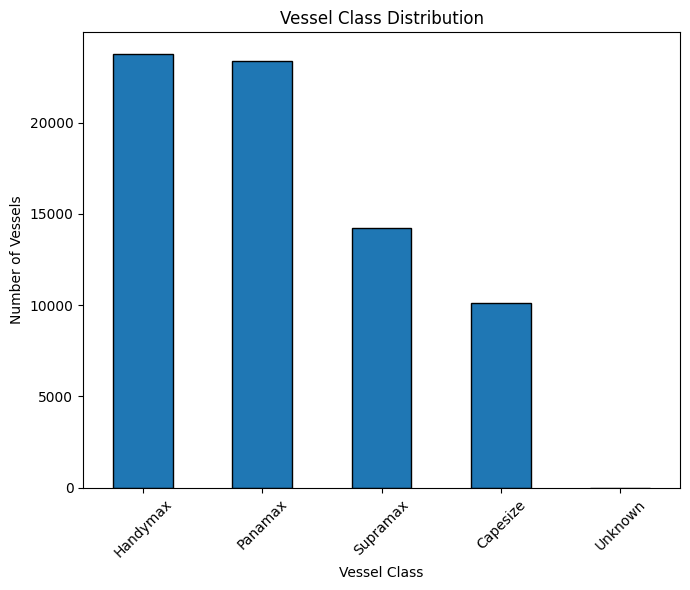

In [15]:
#plotting the barchart for the vessel class
plt.figure(figsize=(7,6))
class_counts.plot(kind='bar',edgecolor='black')

plt.title('Vessel Class Distribution')
plt.xlabel('Vessel Class')
plt.ylabel('Number of Vessels')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [16]:
#Cargo analysis
commodity_counts = cleaned_VP.groupby(['vessel_class', 'vessel_commodity_group_onboard']).size().unstack(fill_value=0)
commodity_counts

vessel_commodity_group_onboard,Agriprods,Breakbulk,Breakbulk/Bulk,Breakbulk/Steels,Bulk,Bulk/Iron Ore,Bulk/Iron Products,Bulk/Steels,Coal,Coal/Iron Ore,Coal/Steels,Fertilizers,Grain,Iron Ore,Iron Products,Iron Products/Steels,Pellets Group,Project Cargoes,Steels
vessel_class,,,,,,,,,,,,,,,,,,,
Capesize,5,5,0,0,644,0,0,0,1046,14,0,5,0,3521,0,0,0,0,0
Handymax,940,1548,1,7,2553,5,4,14,863,0,0,1312,1793,210,56,0,128,197,1927
Panamax,887,501,0,0,2147,0,0,0,4791,5,0,841,3439,621,37,0,18,14,641
Supramax,444,872,5,0,2323,1,0,0,1903,0,2,548,873,263,59,9,22,36,1037


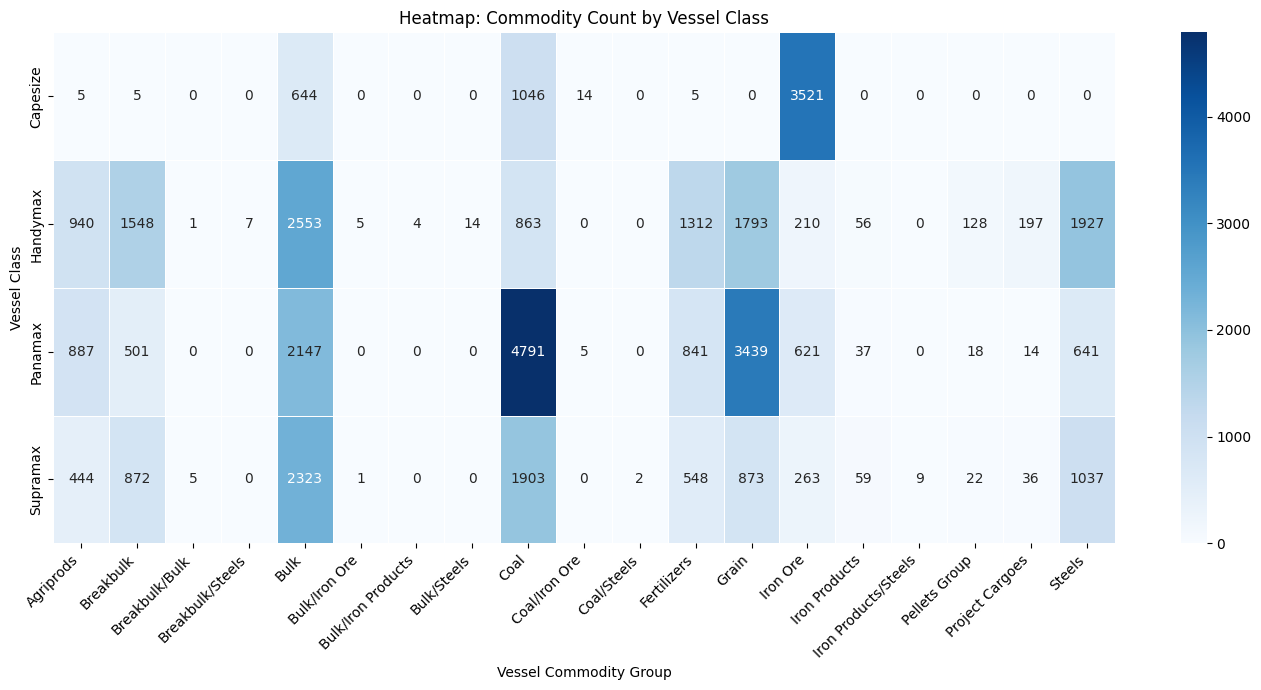

In [17]:
#plotting a heatmap to show the concentration of cargo within each vessel class 
plt.figure(figsize=(14, 7))
sns.heatmap(commodity_counts, annot=True, fmt='d', cmap='Blues', linewidths=0.5)

# Labels and title
plt.title('Heatmap: Commodity Count by Vessel Class')
plt.xlabel('Vessel Commodity Group')
plt.ylabel('Vessel Class')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The heatmap above shows that heavier cargo such as Iron ore or coal is carried by vessels with higher dwt range, whereas the lighter cargo distribution is carried by Handymax, Supramax, and Panamax equally. 

In [18]:
#Geographical Analysis
SEA_polygon_coords = [(90, -11), (105, -11), (130, -11), (140, -5),(140, 10), (125, 25), (105, 23), (90, 20), (90, -11)] #these points are based on googling the approximate boundaries of South East Asian (SEA) region
SEA_polygon = Polygon(SEA_polygon_coords) #creating a polygon based on the coords we entered
cleaned_VP['point'] = cleaned_VP.apply(lambda row: Point(row['ais_long'], row['ais_lat']), axis=1) 
cleaned_VP['in_SEA'] = cleaned_VP['point'].apply(SEA_polygon.contains) #creating a new column which holds boolean value of whether the vessel is in SEA or not
vessels_in_SEA = cleaned_VP[cleaned_VP['in_SEA']] #getting all the vessels within the SEA region

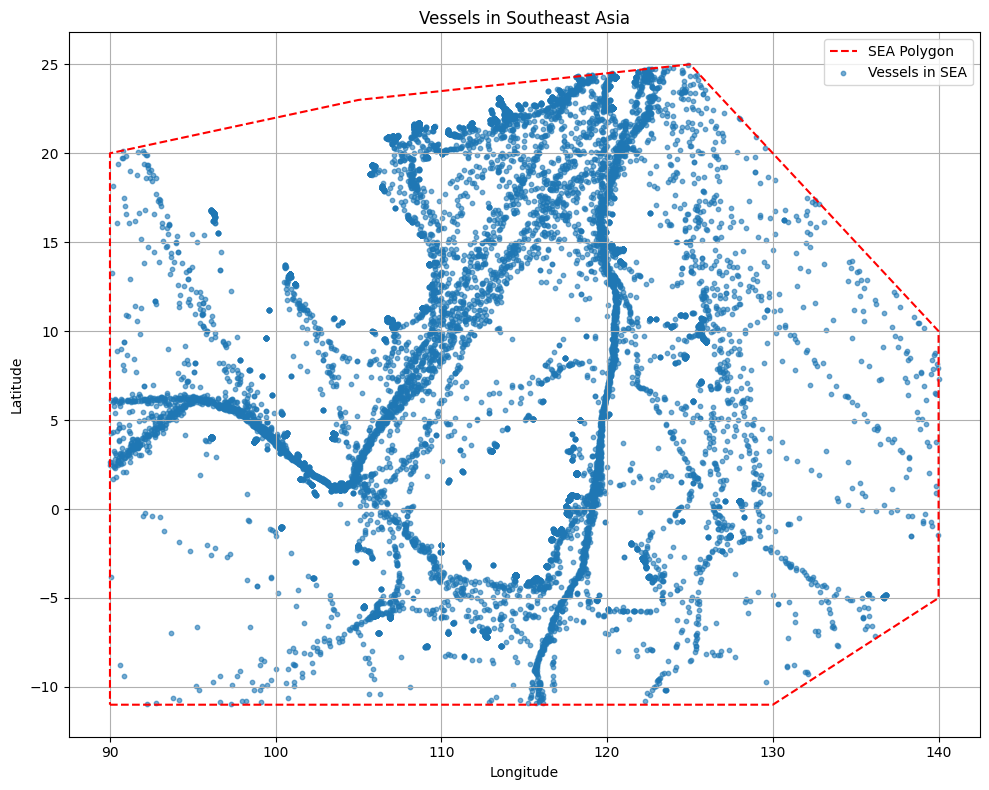

In [19]:
#plotting the boundaries of SEA region and position of each vessel
plt.figure(figsize=(10, 8))
plt.plot(*zip(*SEA_polygon_coords), color='red', linestyle='--', label='SEA Polygon')
plt.scatter(vessels_in_SEA['ais_long'], vessels_in_SEA['ais_lat'], s=10, alpha=0.6, label='Vessels in SEA')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Vessels in Southeast Asia')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
print("Min:", vessels_in_SEA['zone_entry_time'].min())
print("Max:", vessels_in_SEA['zone_entry_time'].max())

Min: 2013-01-01 00:00:00
Max: 2024-08-19 23:59:00


In [21]:
start_date = pd.Timestamp('2024-08-20')
end_date = pd.Timestamp('2024-08-24')
vessels_in_SEA_during_period = vessels_in_SEA[(vessels_in_SEA['zone_entry_time'] <= end_date) & (vessels_in_SEA['zone_out_time'] >= end_date)]

In [22]:
cargo_info = vessels_in_SEA_during_period.copy()

In [23]:
cargo_info = cargo_info.dropna(subset=['vessel_commodity_onboard', 'vessel_commodity_group_onboard'], how='all')


In [24]:
cargo_info['vessel_commodity_group_onboard'].value_counts()

vessel_commodity_group_onboard
Coal                473
Bulk                202
Iron Ore            121
Grain                97
Steels               96
Breakbulk            76
Fertilizers          39
Agriprods            38
Pellets Group         3
Project Cargoes       2
Breakbulk/Steels      2
Coal/Iron Ore         1
Name: count, dtype: int64

The top two exports from SEA region are coal and bulk which could be any of the dry bulk such as cement or fertilizers. 

In [25]:
print("Top destination ports:")
cargo_info['real_destination_port_name'].value_counts()

Top destination ports:


real_destination_port_name
Tangofa     23
Machong     23
Weda Bay    22
Qinzhou     19
Rizhao      18
            ..
Penang       1
Sohar        1
Mongla       1
Weifang      1
Fukuyama     1
Name: count, Length: 329, dtype: int64

In [26]:
print("Top destination countries:")
cargo_info['real_destination_country_name'].value_counts()

Top destination countries:


real_destination_country_name
China                        429
Indonesia                    172
Vietnam                       89
India                         73
Malaysia                      66
Philippines                   66
Taiwan, Province of China     39
Japan                         38
Thailand                      37
Bangladesh                    22
Korea South                   20
Singapore                     17
Australia                      7
Brazil                         6
USA                            5
Turkiye                        4
New Zealand                    4
United Arab Emirates           4
Italy                          2
Hong Kong                      2
South Africa                   2
Belgium                        2
Sri Lanka                      2
Russia                         2
Spain                          2
Algeria                        2
Saudi Arabia                   2
Togo                           1
Nigeria                        1
Brunei Daruss

In [27]:
print("Top destination zones:")
cargo_info['real_destination_zone_name'].value_counts()

Top destination zones:


real_destination_zone_name
Far East                             530
South East Asia                      449
East Coast India                      62
West Coast India                      36
Arabian Gulf                          10
East Coast South America               6
East Aussie                            6
South West Africa                      5
NoPac                                  4
New Zealand                            4
West Mediterranean                     4
East Mediterranean                     4
Antwerp Rotterdam Amsterdam Ghent      3
Black Sea                              3
North Coast South America              3
South Africa                           2
East Africa                            2
East Coast U.S                         1
North West Africa                      1
West Aussie                            1
United Kingdom Ireland                 1
Red Sea                                1
West Coast Central America             1
Baltic                        

Most of the cargo is heading to China, in the Far East zone

In [28]:
vessels_in_SEA_IMO = cargo_info['imo']

In [29]:
vessel_characteristics = vessel_characteristics[vessel_characteristics['imo'].isin(vessels_in_SEA_IMO)]

In [30]:
vessel_characteristics['tc_operator'].value_counts()

tc_operator
OLDENDORFF CARRIERS               40
COSCO SHIPPING BULK CO            17
GURITA LINTAS SAMUDERA            14
LUMOSO PRATAMA LINE               12
STAR BULK CARRIERS CORP           12
                                  ..
TAYLOR MARITIME HK                 1
GNG OCEAN SHIPPING                 1
HYDROUSSA NAVIGATION               1
VALIANT SHIPPING LONDON            1
YANGZHOU YONGWEI SHIPPING SERV     1
Name: count, Length: 567, dtype: int64

In [31]:
oldendorff_info = vessel_characteristics[vessel_characteristics['tc_operator'].str.upper() == 'OLDENDORFF CARRIERS']

In [32]:
oldendorff_beneficial_owners = oldendorff_info['beneficial_owner'].unique()

In [33]:
oldendorff_beneficial_owners

array(['KANELLAKIS', 'BRAVE MARITIME', 'POLEMBROS SHIPPING',
       'OLDENDORFF E', 'BANK OF COMMUNICATIONS',
       'EVERBRIGHT FINANCIAL LEASING', 'CHINA DEVELOPMENT BANK',
       'SANHE HOPEFULL GRAIN', 'ECONOMOU GROUP', 'SHIH WEI NAVIGATION',
       'PAVIMAR SA', 'EFSTATHIOU A', 'CHINA COSCO SHIPPING',
       'CHRONOS SHIPPING', 'FOREMOST GROUP',
       'TAIPING & SINOPEC FINANCIAL LEASING',
       'MINYI TIANJIN SHIP LEASING', 'CHINA MERCHANTS GROUP',
       'HALCOUSSIS Z&G', 'TAGASHIRA KAIUN', 'KUOK GROUP',
       'INDOFOOD SUKSES MAKMUR', 'WEHR REEDEREI', 'DALIAN ZHIDA SM',
       'MINSHENG FINANCIAL LEASING', 'ZODIAC GROUP'], dtype=object)

In [34]:
cosco_info = vessel_characteristics[vessel_characteristics['tc_operator'].str.upper() == 'COSCO SHIPPING BULK CO']
cosco_beneficial_owners = cosco_info['beneficial_owner'].unique()
cosco_beneficial_owners

array(['CHINA COSCO SHIPPING', 'CHINA DEVELOPMENT BANK'], dtype=object)

The most active operators in the region were OLDENDORFF CARRIERS which has multiple beneficial owners. Additionally the second active operator in the region was COSCO SHIPPING BULK CO, the benficial owners of this are China Cosco shipping and China Development bank

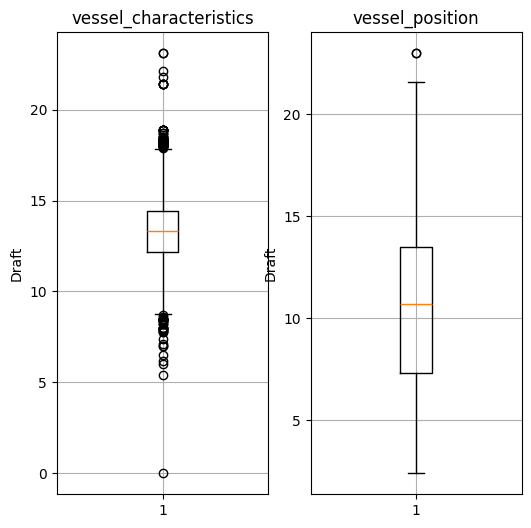

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(6,6))

axes[0].boxplot(vessel_characteristics['draft'].dropna(), vert=True)
axes[0].set_title('vessel_characteristics')
axes[0].set_ylabel('Draft')
axes[0].grid(True)
axes[1].boxplot(cargo_info['ais_draft'].dropna(), vert=True)
axes[1].set_title('vessel_position')
axes[1].set_ylabel('Draft')
axes[1].grid(True)

plt.show()

The above plot shows the box plots of drafts from both vessel_postions and vessel_characteristics. It can be interpreted that the draft in vessel_characteristics is the maximum draft of the ship. Based on this information we can calculate the loading ratio which would be ais_draft/draft. If this ratio is close to 1 that would mean the ship has finihsed loading. If it is closer to zero that means the vessel is empty. 